## Import

In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score
)

## Download CIFAR-10 Dataset

In [4]:
# Check if CIFAR-10 dataset is downloaded


def load_CIFAR10(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader, train_dataset, test_dataset

train_loader, test_loader, train_dataset, test_dataset = load_CIFAR10()

## Preview dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654902..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data 

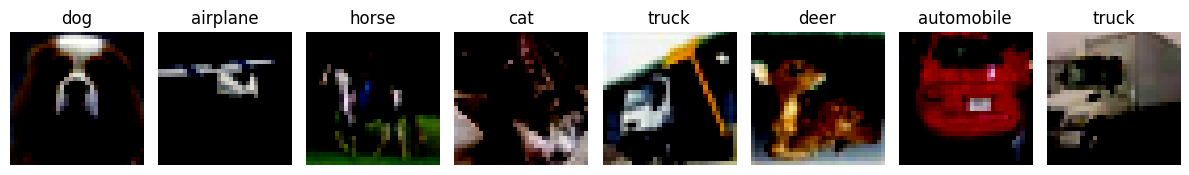

In [5]:

# Class labels for CIFAR-10
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = train_dataset.classes

# Grab a batch
images, labels = next(iter(train_loader))

# Convert from tensors to numpy for plotting


def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')


# Plot images in a row
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()


## Load trained ResNet50 model in

In [6]:
from ResNet50WithHyperperameter import ResNet50

# Load teacher architecture
teacher_model = ResNet50(num_classes=10)

# Load the pre-trained weights
teacher_path = "ResNet50_Teacher.pth"
teacher_model.load_state_dict(torch.load(teacher_path, map_location='cpu'))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.to(device)
teacher_model.cuda()

# Set to evaluation mode and freeze parameters
print(device)
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = teacher_model(images)
        probas = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probas, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probas.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# 3) Overall accuracy & full report
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}\n")


/home/ap/Documents/AIToolsProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


100%|██████████| 157/157 [00:05<00:00, 27.96it/s]


Overall Accuracy: 0.7766



## Load student model

In [7]:
from Simple_CNN_V1_model import SimpleCNN
# Load student architecture
student_model = SimpleCNN(num_classes=10)
# Move to device
student_model.to(device)

# Load the pre-trained weights
student_path = "student_model.pth"
student_model.load_state_dict(torch.load(student_path, map_location='cpu'))
# Move to device
student_model.to(device)
# Set to training mode
student_model.train()
# Define loss function and optimizer
optimizer = optim.Adam(student_model.parameters(), lr=0.001)


## Distillation loss

In [11]:


def distillation_loss(student_logits, teacher_logits, targets, T=2.0, alpha=0.5):
    """
    student_logits: output from student network (before softmax)
    teacher_logits: output from teacher network (before softmax)
    targets: ground truth labels
    T: temperature for softening
    alpha: weight between soft and hard losses
    """
    # Hard loss
    hard_loss = F.cross_entropy(student_logits, targets)
    
    # Clamp logits to avoid inf/NaN
    student_logits = torch.clamp(student_logits, -100, 100)
    teacher_logits = torch.clamp(teacher_logits, -100, 100)

    # Soft loss (KL divergence with softened logits)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    soft_teacher = F.softmax(teacher_logits / T, dim=1)
    soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

    #print("Hard loss:", hard_loss.item(), "Soft loss:", soft_loss.item())
    # Combined loss
    return alpha * hard_loss + (1 - alpha) * soft_loss

## Training loop

In [12]:
# Initialize student model

def train_student(student_model, teacher_model, train_loader, optimizer, device, epochs=10, T=2.0, alpha=0.5):
    student_model.train()
    teacher_model.eval()

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through both models
            student_logits = student_model(images)
            with torch.no_grad():
                teacher_logits = teacher_model(images)

            # Compute distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, T=T, alpha=alpha)
            

            # Backprop and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()   

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


In [13]:
# Train the student model
train_student(student_model, teacher_model, train_loader, optimizer, device, epochs=10, T=2.0, alpha=0.5)

  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Export model

In [ ]:
torch.save(student_model.state_dict(), 'KD_model.pth')


## Evaluate the model

In [ ]:
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        probas = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probas, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probas.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# 3) Overall accuracy & full report
overall_acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_acc:.4f}\n")

100%|██████████| 157/157 [00:02<00:00, 67.72it/s]


Overall Accuracy: 0.7901

